In [1]:
import os
import re
import shutil
import string
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import losses

In [2]:
print(tf.__version__)

2.7.0


#### Download and explore the IMDB dataset

In [3]:
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

In [4]:
dataset = tf.keras.utils.get_file('aclImdb_v1', url, 
                                  untar=True, cache_dir='.', cache_subdir='')

In [5]:
dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')
os.listdir(dataset_dir)

['imdbEr.txt', 'test', 'imdb.vocab', 'README', 'train']

In [6]:
train_dir = os.path.join(dataset_dir, 'train')
os.listdir(train_dir)

['urls_unsup.txt',
 'neg',
 'urls_pos.txt',
 'unsup',
 'urls_neg.txt',
 'pos',
 'unsupBow.feat',
 'labeledBow.feat']

In [7]:
sample_file = os.path.join(train_dir, 'pos/1181_9.txt')
with open(sample_file) as f:
  print(f.read())

Rachel Griffiths writes and directs this award winning short film. A heartwarming story about coping with grief and cherishing the memory of those we've loved and lost. Although, only 15 minutes long, Griffiths manages to capture so much emotion and truth onto film in the short space of time. Bud Tingwell gives a touching performance as Will, a widower struggling to cope with his wife's death. Will is confronted by the harsh reality of loneliness and helplessness as he proceeds to take care of Ruth's pet cow, Tulip. The film displays the grief and responsibility one feels for those they have loved and lost. Good cinematography, great direction, and superbly acted. It will bring tears to all those who have lost a loved one, and survived.


In [8]:
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

In [9]:
batch_size = 32
seed = 42
raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed,
)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


In [10]:
for text_batch, label_batch in raw_train_ds.take(1):
    for i in range(3):
        print('Review', text_batch.numpy()[i])
        print('Label', label_batch.numpy()[i])

Review b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'
Label 0
Review b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characters whose perspective of life changes as they get into 

In [11]:
print("Label 0 corresponds to", raw_train_ds.class_names[0])
print("Label 1 corresponds to", raw_train_ds.class_names[1])

Label 0 corresponds to neg
Label 1 corresponds to pos


In [12]:
raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed
)

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [13]:
raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/test',
    batch_size=batch_size
)

Found 25000 files belonging to 2 classes.


In [14]:
def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
    return tf.strings.regex_replace(stripped_html, '[%s]' % re.escape(string.punctuation), '')

In [15]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [16]:
max_features = 10000
sequence_length = 250
vectorize_layer = tf.keras.layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length
)

In [17]:
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

In [18]:
def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label

In [19]:
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)
print("Label", raw_train_ds.class_names[first_label])
print("Vectorized review", vectorize_text(first_review, first_label))

Review tf.Tensor(b'Great movie - especially the music - Etta James - "At Last". This speaks volumes when you have finally found that special someone.', shape=(), dtype=string)
Label neg
Vectorized review (<tf.Tensor: shape=(1, 250), dtype=int64, numpy=
array([[  86,   17,  260,    2,  222,    1,  571,   31,  229,   11, 2418,
           1,   51,   22,   25,  404,  251,   12,  306,  282,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
       

In [20]:
vectorize_layer(text_batch[:1])

<tf.Tensor: shape=(1, 250), dtype=int64, numpy=
array([[  86,   17,  260,    2,  222,    1,  571,   31,  229,   11, 2418,
           1,   51,   22,   25,  404,  251,   12,  306,  282,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,   

In [21]:
vectorize_layer(text_batch)

<tf.Tensor: shape=(32, 250), dtype=int64, numpy=
array([[  86,   17,  260, ...,    0,    0,    0],
       [  10,  237, 2350, ...,    0,    0,    0],
       [  48,    4, 1285, ...,    0,    0,    0],
       ...,
       [ 462,    2,    1, ...,    0,    0,    0],
       [  48, 4948,  120, ...,  477,  300,   14],
       [  29,    4,   52, ...,    0,    0,    0]])>

In [22]:
print("1287 ---> ",vectorize_layer.get_vocabulary()[1287])
print(" 313 ---> ",vectorize_layer.get_vocabulary()[313])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

1287 --->  silent
 313 --->  night
Vocabulary size: 10000


In [23]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

In [24]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [25]:
embedding_dim = 16
model = tf.keras.Sequential([
  layers.Embedding(max_features + 1, embedding_dim),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(1)])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          160016    
                                                                 
 dropout (Dropout)           (None, None, 16)          0         
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 160,033
Trainable params: 160,033
Non-trainable params: 0
__________________________________________________

In [26]:
model.compile(loss=losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

In [27]:
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/10
625/625 [==============================] - 5s 7ms/step - loss: 0.6650 - binary_accuracy: 0.6930 - val_loss: 0.6155 - val_binary_accuracy: 0.7714
Epoch 2/10
625/625 [==============================] - 3s 5ms/step - loss: 0.5485 - binary_accuracy: 0.8004 - val_loss: 0.4980 - val_binary_accuracy: 0.8226
Epoch 3/10
625/625 [==============================] - 3s 5ms/step - loss: 0.4439 - binary_accuracy: 0.8456 - val_loss: 0.4198 - val_binary_accuracy: 0.8470
Epoch 4/10
625/625 [==============================] - 3s 5ms/step - loss: 0.3775 - binary_accuracy: 0.8652 - val_loss: 0.3735 - val_binary_accuracy: 0.8614
Epoch 5/10
625/625 [==============================] - 3s 4ms/step - loss: 0.3364 - binary_accuracy: 0.8792 - val_loss: 0.3447 - val_binary_accuracy: 0.8678
Epoch 6/10
625/625 [==============================] - 3s 5ms/step - loss: 0.3048 - binary_accuracy: 0.8880 - val_loss: 0.3260 - val_binary_accuracy: 0.8712
Epoch 7/10
625/625 [==============================] - 4s 7ms/ste

In [28]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

782/782 [==============================] - 3s 3ms/step - loss: 0.3103 - binary_accuracy: 0.8740
Loss:  0.31028226017951965
Accuracy:  0.873960018157959


In [29]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

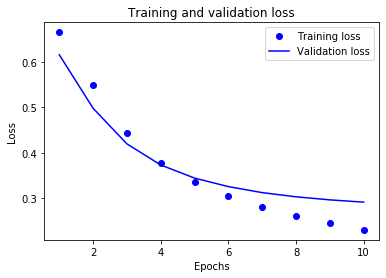

In [30]:
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

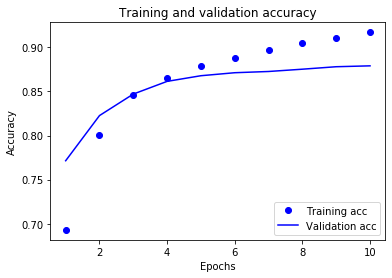

In [31]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

In [32]:
export_model = tf.keras.Sequential([
  vectorize_layer,
  model,
  layers.Activation('sigmoid')
])

export_model.compile(
    loss=losses.BinaryCrossentropy(from_logits=False), optimizer="adam", metrics=['accuracy']
)

# Test it with `raw_test_ds`, which yields raw strings
loss, accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)

782/782 [==============================] - 4s 4ms/step - loss: 0.3103 - accuracy: 0.8740
0.873960018157959


In [33]:
examples = [
  "The movie was great!",
  "The movie was okay.",
  "The movie was terrible..."
]

export_model.predict(examples)

array([[0.6290698 ],
       [0.45150813],
       [0.3673576 ]], dtype=float32)

In [34]:
import tensorflow_hub as hub

In [44]:
AUTOTUNE = tf.data.AUTOTUNE
train_data = raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)
validation_data = raw_val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_data = raw_test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [45]:
train_examples_batch, train_labels_batch = next(iter(train_data))

In [48]:
train_examples_batch[:10]

<tf.Tensor: shape=(10,), dtype=string, numpy=
array([b"The idea ia a very short film with a lot of information. Interesting, entertaining and leaves the viewer wanting more. The producer has produced a short film of excellent quality that cannot be compared to any other short film that I have seen. I have rated this film at the highest possible rating. I also recommend that it is shown to office managers and business people in any establishment. What comes out of it is the fact that people with ideas are never listened to, their voice is never heard. It is a lesson to be learned by any office that wants to go forward. I hope that the produced will produce a second part to this 'idea'. I look forward to viewing the sequence. Once again congrats to Halaqah media in producing a film of excellence and quality with a lesson in mind.",
       b"When the Chamberlain family is camping near Ayers Rock, Australia, Lindy Chamberlain (Meryl Streep) sees her baby being dragged out of their tent by 

In [50]:
train_labels_batch[:10]

<tf.Tensor: shape=(10,), dtype=int32, numpy=array([1, 1, 1, 1, 0, 1, 1, 0, 0, 1], dtype=int32)>

In [51]:
embedding = "https://tfhub.dev/google/nnlm-en-dim50/2"
hub_layer = hub.KerasLayer(embedding, input_shape=[], 
                           dtype=tf.string, trainable=True)
hub_layer(train_examples_batch[:3])

<tf.Tensor: shape=(3, 50), dtype=float32, numpy=
array([[ 0.5045248 ,  0.29073712, -0.10621537,  0.7945034 , -0.33211353,
         0.01349098,  0.02329711, -0.12343552, -0.6496864 ,  0.31324264,
         0.04663875, -0.02553531,  0.00601637, -0.06339172,  0.09603542,
        -0.5886627 , -0.47584644, -0.03429287,  0.14363053, -0.7564154 ,
        -0.01489634, -0.3033137 ,  0.6212943 , -0.08580067, -0.42039713,
         0.3771352 , -1.1351146 ,  0.14161079,  0.3056061 , -0.416476  ,
        -0.07844821,  0.2665901 ,  0.48226932, -0.3328706 , -0.22207235,
         0.417762  ,  0.21804519, -0.5124942 ,  0.22578573, -0.6698711 ,
        -0.16419195,  0.1177833 , -0.11661649,  0.6058118 , -0.5513534 ,
        -0.69507986, -0.18488352, -0.5469507 ,  0.34975073,  0.33882785],
       [ 0.98699623,  0.06491525,  0.03633004,  0.4821963 ,  0.05657617,
        -0.37205473, -0.05558916, -0.07960363, -0.44414476,  0.3856516 ,
         0.10717104,  0.03600306, -0.25972778,  0.11482243, -0.22349404,
 

In [52]:
model = tf.keras.Sequential([
    hub_layer,
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1)
])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 50)                48190600  
                                                                 
 dense_1 (Dense)             (None, 16)                816       
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 48,191,433
Trainable params: 48,191,433
Non-trainable params: 0
_________________________________________________________________


In [53]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [54]:
history = model.fit(train_data,
                    epochs=10,
                    validation_data=validation_data,
                    verbose=1)

Epoch 1/10
625/625 [==============================] - 541s 865ms/step - loss: 0.4284 - accuracy: 0.7736 - val_loss: 0.2992 - val_accuracy: 0.8672
Epoch 2/10
625/625 [==============================] - 502s 803ms/step - loss: 0.1749 - accuracy: 0.9337 - val_loss: 0.3085 - val_accuracy: 0.8766
Epoch 3/10
625/625 [==============================] - 495s 792ms/step - loss: 0.0777 - accuracy: 0.9756 - val_loss: 0.3940 - val_accuracy: 0.8686
Epoch 4/10
625/625 [==============================] - 484s 775ms/step - loss: 0.0300 - accuracy: 0.9933 - val_loss: 0.4510 - val_accuracy: 0.8628
Epoch 5/10
625/625 [==============================] - 518s 829ms/step - loss: 0.0121 - accuracy: 0.9983 - val_loss: 0.5294 - val_accuracy: 0.8604
Epoch 6/10
625/625 [==============================] - 524s 838ms/step - loss: 0.0055 - accuracy: 0.9993 - val_loss: 0.6077 - val_accuracy: 0.8614
Epoch 7/10
625/625 [==============================] - 504s 807ms/step - loss: 0.0021 - accuracy: 0.9998 - val_loss: 0.6363 -

In [57]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

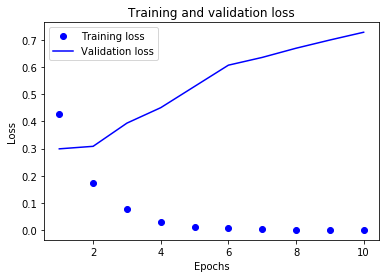

In [60]:
#acc = history_dict['binary_accuracy']
#val_acc = history_dict['val_binary_accuracy']
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

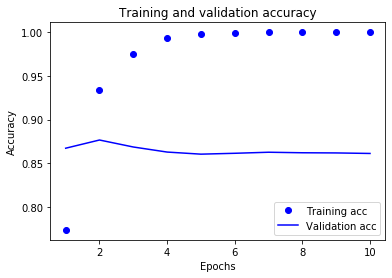

In [61]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

In [62]:
batch_size = 512
seed = 42
raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed,
)
raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed
)
raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/test',
    batch_size=batch_size
)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
Found 25000 files belonging to 2 classes.


In [63]:
AUTOTUNE = tf.data.AUTOTUNE
train_data = raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)
validation_data = raw_val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_data = raw_test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [66]:
train_examples_batch, train_labels_batch = next(iter(train_data))
train_examples_batch.shape

TensorShape([512])

In [68]:
embedding = "https://tfhub.dev/google/nnlm-en-dim50/2"
hub_layer = hub.KerasLayer(embedding, input_shape=[], dtype=tf.string, trainable=True)
hub_layer(train_examples_batch[:1])

<tf.Tensor: shape=(1, 50), dtype=float32, numpy=
array([[ 0.35038498,  0.18631187, -0.20598061,  0.734408  ,  0.09712207,
         0.10460646, -0.03197865, -0.286807  , -0.56212646,  0.7507804 ,
         0.22896829,  0.08529465, -0.19399638,  0.08604459, -0.30772176,
        -0.29384366, -0.40436515,  0.2741783 ,  0.2226088 , -0.6067508 ,
         0.07088511, -0.345723  ,  0.20198293,  0.11953884, -0.48120436,
         0.15618281, -1.1036073 ,  0.0554509 ,  0.34253284, -0.48720604,
        -0.41076913,  0.03689497,  0.31100863, -0.17275989, -0.4597939 ,
         0.3340749 ,  0.22789572, -0.262603  ,  0.00294064, -0.7623814 ,
        -0.11053871,  0.18149124, -0.23120771,  0.13907632, -0.13585573,
        -0.24931003, -0.36280632, -0.33359784,  0.08231147, -0.06506847]],
      dtype=float32)>

In [69]:
model = tf.keras.Sequential([
    hub_layer,
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1)
])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_2 (KerasLayer)  (None, 50)                48190600  
                                                                 
 dense_3 (Dense)             (None, 16)                816       
                                                                 
 dense_4 (Dense)             (None, 1)                 17        
                                                                 
Total params: 48,191,433
Trainable params: 48,191,433
Non-trainable params: 0
_________________________________________________________________


In [70]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [71]:
history = model.fit(train_data,
                    epochs=10,
                    validation_data=validation_data,
                    verbose=1)

Epoch 1/10
40/40 [==============================] - 40s 943ms/step - loss: 0.6234 - accuracy: 0.5950 - val_loss: 0.5489 - val_accuracy: 0.6722
Epoch 2/10
40/40 [==============================] - 35s 860ms/step - loss: 0.4581 - accuracy: 0.7734 - val_loss: 0.4170 - val_accuracy: 0.7950
Epoch 3/10
40/40 [==============================] - 34s 862ms/step - loss: 0.3175 - accuracy: 0.8687 - val_loss: 0.3402 - val_accuracy: 0.8500
Epoch 4/10
40/40 [==============================] - 32s 792ms/step - loss: 0.2248 - accuracy: 0.9147 - val_loss: 0.3097 - val_accuracy: 0.8646
Epoch 5/10
40/40 [==============================] - 35s 869ms/step - loss: 0.1620 - accuracy: 0.9448 - val_loss: 0.3005 - val_accuracy: 0.8720
Epoch 6/10
40/40 [==============================] - 32s 812ms/step - loss: 0.1165 - accuracy: 0.9638 - val_loss: 0.3022 - val_accuracy: 0.8734
Epoch 7/10
40/40 [==============================] - 32s 789ms/step - loss: 0.0834 - accuracy: 0.9776 - val_loss: 0.3080 - val_accuracy: 0.8742

In [72]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

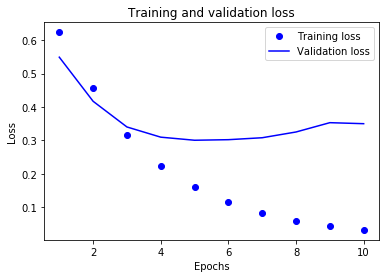

In [73]:
#acc = history_dict['binary_accuracy']
#val_acc = history_dict['val_binary_accuracy']
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

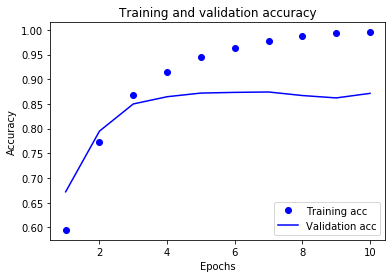

In [74]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()